## Project 5 - Vehicle Detection and Tracking

##### By Matthew Zimmer - Future Self-Driving Car Engineer

[GitHub](https://github.com/matthewzimmer) | [LinkedIn](https://www.linkedin.com/in/matthewazimmer)

---

**Vehicle Detection Project**

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

[//]: # (Image References)
[image1]: ./examples/car_not_car.png
[image2]: ./examples/HOG_example.jpg
[image3]: ./examples/sliding_windows.jpg
[image4]: ./examples/sliding_window.jpg
[image5]: ./examples/bboxes_and_heat.png
[image6]: ./examples/labels_map.png
[image7]: ./examples/output_bboxes.png
[video1]: ./project_video.mp4

## [Rubric](https://review.udacity.com/#!/rubrics/513/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Vehicle-Detection/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!

> **CRITICAL NOTE** I treated this notebook as a comprehensive tutorial walking you from start to finish, top down, starting from calibrating the camera all the way to the very last step of drawing the detected lane region into the road. The very last cell of this notebook offers you the ability to control the hyper parameters used by my pipeline and either test them on a single image (the default setting) or test the sample the entire video.

---

#### Python imports

In [1]:
import numpy as np
import cv2
import glob
import os
import pickle

import matplotlib
matplotlib.use('qt5agg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.core.display import Image, display
from IPython.display import YouTubeVideo
def render_youtube_video(video_id, width=880, height=495):
    return YouTubeVideo(video_id, width=width, height=height)

---

#### Pipeline Operations

Pipeline operations are the principle driving force for this project. Each implementation of `PipelineOp` is a modular, reusable algorithm which, in its most basic form, performs a single operation on an image.

**[PipelineOp](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/pipeline_ops.py#L10-L39)** has a simple interface with only 2 requirements to satisfy the contract:

1. Declare a constructor with inputs necessary to perform the operation. To truly adhere to the nature of encapsulation and immutability, I initialize private variables so as not to expose them publicly.

2. Implement your **[#perform](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/pipeline_ops.py#L31-L32)** method

    * Your implementation must `return self`. This provides support to perform the op and immediately assign a chained call to `#output` to a local variable. Example:
    
    ```python
    out = PipelineOp().output()
    ```

    * Declare your op's final output by calling **[#_apply_output](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/pipeline_ops.py#L37-L39)** once you've performed your operation. Note the value and data type of output is arbitraily defined by your operation. Documenting this information is encouraged.
    
This architecture provides flexibility to implementing more complicated algorithms that have many moving parts while still adhering to the contract by producing a single arbitrary output object (e.g., Dictionary, Image, Array). I demonstrate a healthy mixture of both simple and complex **[PipelineOp](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/pipeline_ops.py#L10-L39)** implementations in this project. For example, **[CameraCalibrationOp](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/lane_detection_ops.py#L12-L230)** and **[LaneAssistOp](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/lane_detection_ops.py#L402-L677)** are great examples of a complex algorithm whereas **[ColorThreshOp](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/pipeline_ops.py#L63-L72)** is a great example of a minimalistic algorithm, both adhering to the same **PipelineOp** contract.

In [2]:
from lib.pipeline_ops import *
from lib.vehicle_detection_ops import *
from lib.lane_detection_ops import *
from lib.datasets import *

calibration_op = None

#### Project Functions

In [41]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from skimage.feature import hog

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = len(cars)
# Read in the image
# image = mpimg.imread(cars[ind])
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

class Params():
    def __init__(self, colorspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
        self.colorspace = colorspace # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = orient # typically between 6 and 12
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel # Can be 0, 1, 2, or "ALL"

---

### Camera Calibration

My entire camera calibration algorithm may be found inside of **[CameraCalibrationOp#perform](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/lane_detection_ops.py#L54-L68)**. I've also exposed the **[#undistort](https://github.com/matthewzimmer/CarND-Vehicle-Detection-P5/blob/107239a1530cc3b1f56016483941b28e5b70c26a/lib/lane_detection_ops.py#L70-L83)** method which will undistort any raw image (ideally images taken by that camera but no code was put in place to validate camera source of image though EXIF data would be perfect place to look first).

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

![calibration1.jpg](camera_cal/undistorted/calibration1.jpg)

In [11]:
def calibrate_camera():
    global calibration_op
    
    if calibration_op == None:
        # base edges - doesn't work for all images in camera_cal directory (i.e., 1, 4, 5)
        calibration_images=glob.glob('camera_cal/calibration*.jpg')

        # I will now inject this calibration_op instance later on 
        # into my pipeline principally used to undistort the 
        # raw image.
        calibration_op = CameraCalibrationOp(
            calibration_images=calibration_images, 
            x_inside_corners=9, 
            y_inside_corners=6
        ).perform()
    return calibration_op
calibrate_camera()

---

### Histogram of Oriented Gradients (HOG)

#### 1. Explain how (and identify where in your code) you extracted HOG features from the training images.

The code for all steps from here on out is contained in the **Pipeline Operations** code cell at the beginning of the IPython notebook.

I started by reading in all the `vehicle` and `non-vehicle` images.  Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

![alt text][image1]

In [12]:
ds = CarsNotCarsDatasetOp().perform()
cars = ds.cars()
notcars = ds.not_cars()

print('    # Cars: ' + str(len(cars)))
print('# Not cars: ' + str(len(notcars)))

    # Cars: 1196
# Not cars: 1125


Here is an example of one of each of the `vehicle` and `non-vehicle` classes:

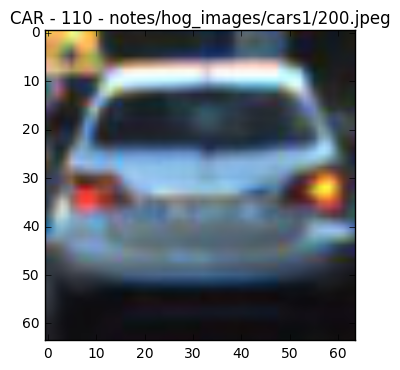

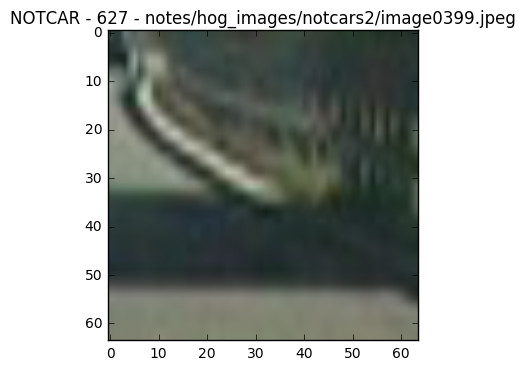

In [13]:
# Generate a random index to look at a car image
ind_cars = np.random.randint(0, len(cars))

plt.title("CAR - {} - {}".format(ind_cars,cars[ind_cars]))
plt.imshow(mpimg.imread(cars[ind_cars]))
plt.show()

# Generate a random index to look at a notcar image
ind_notcars = np.random.randint(0, len(notcars))

plt.title("NOTCAR - {} - {}".format(ind_notcars, notcars[ind_notcars]))
plt.imshow(mpimg.imread(notcars[ind_notcars]))
plt.show()

I then explored different color spaces and different `skimage.hog()` parameters (`orientations`, `pixels_per_cell`, and `cells_per_block`).  I grabbed random images from each of the two classes and displayed them to get a feel for what the `skimage.hog()` output looks like.

Here is an example using the `YCrCb` color space and HOG parameters of `orientations=8`, `pixels_per_cell=(8, 8)` and `cells_per_block=(2, 2)`:


![alt text][image2]

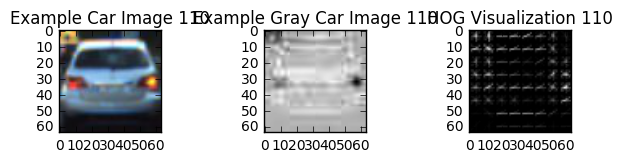

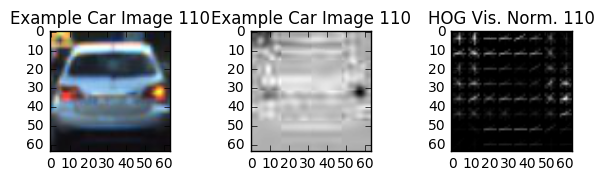

In [14]:
# Read in the image
image = mpimg.imread(cars[ind_cars])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)[:,:,2]

if True:
    # Define HOG parameters
    orient = 8
    pix_per_cell = 8
    cell_per_block = 2

    # Call our function with vis=True to see an image output
    features, hog_image = HOGExtractorOp(
        gray, orient, 
        pix_per_cell, cell_per_block, 
        visualize=True,
        feature_vec=False, 
        transform_sqrt=False
    ).output()


    # Plot the examples
    fig = plt.figure()
    plt.subplot(131)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image {}'.format(str(ind_cars)))
    plt.subplot(132)
    plt.imshow(gray, cmap='gray')
    plt.title('Example Gray Car Image {}'.format(str(ind_cars)))
    plt.subplot(133)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Visualization {}'.format(str(ind_cars)))
    plt.tight_layout()
    
    # Call our function with vis=True to see an image output
    features, hog_image = HOGExtractorOp(
        gray, orient, 
        pix_per_cell, cell_per_block, 
        visualize=True,
        feature_vec=False, 
        transform_sqrt=True
    ).output()

    # Plot the examples
    fig = plt.figure()
    plt.subplot(131)
    plt.imshow(image, cmap='gray')
    plt.title('Example Car Image {}'.format(str(ind_cars)))
    plt.subplot(132)
    plt.imshow(gray, cmap='gray')
    plt.title('Example Car Image {}'.format(str(ind_cars)))
    plt.subplot(133)
    plt.imshow(hog_image, cmap='gray')
    plt.title('HOG Vis. Norm. {}'.format(str(ind_cars)))
    plt.tight_layout()

#### 2. Explain how you settled on your final choice of HOG parameters.

I tried various combinations of parameters and the one with the highest accuracy is ultimately what I chose for my model.

Each item outlined in the table below is initiatlized and commented out in the cell below. Feel free to have a go at it.


|  colorspace | orient | pix_per_cell | cell_per_block | hog_channel  |   accuracy   |
|:--------:|:------------:|:------------:|:------------:|:------------:|:------------:|
| YUV | 9 | 8 | 2 | 0 | 97% |
| YUV | 8 | 8 | 2 | 0 | 98% |
| YUV | 8 | 8 | 2 | ALL | 98.5% |
| YUV | 8 | 7 | 2 | ALL | 99% |
| YCrCb | 8 | 7 | 2 | ALL | 99-100% |

#### 3. Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

I trained a linear SVM using...

1. I instantiate `Params` with the HOG parameters that yielded the best overall prediction accuracy against the test set.

2. I then invoke `#extract_features` which extracts HOG features from each training image for both the cars and not cars datasets passing the same parameter to each.

3. I then stack both cars and not cars datasets into a single array called `X` which correspond to my training features.

4. Using sklearn.preprocessing.StandardScaler(), I normalize my feature vectors for training my classifier. 

5. Then I apply the same scaling to each of the feature vectors.

6. Next, I created my training labels by using np.hstack which assigns the label `1` for each item from the `cars` training set and the label `0` for each imem in the `notcars` training set.

7. Then I split up the data into randomized 80% training and 20% test sets using `sklearn.model_selection.train_test_split`. This automatically shuffles my dataset.

8. Using `sklearn.svm.LinearSVC`, I fit my training features and labels to the model.

9. Finally, I run a prediction against my model and print some statistics to the console below the next Jupyter Notebook cell.

In [15]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

################################################################################################################
# params = Params(colorspace='YUV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0) #97%
# params = Params(colorspace='YUV', orient=8, pix_per_cell=8, cell_per_block=2, hog_channel=0) #98%
# params = Params(colorspace='YUV', orient=8, pix_per_cell=8, cell_per_block=2, hog_channel='ALL') #98.5%
# params = Params(colorspace='YUV', orient=8, pix_per_cell=7, cell_per_block=2, hog_channel='ALL') #99%
# params = Params(colorspace='YCrCb', orient=8, pix_per_cell=7, cell_per_block=2, hog_channel='ALL') #99-100%
params = Params(colorspace='YCrCb', orient=7, pix_per_cell=4, cell_per_block=2, hog_channel='ALL') #99-100%
################################################################################################################

t=time.time()
car_features = extract_features(cars, color_space=params.colorspace, orient=params.orient, 
                        pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block, 
                        hog_channel=params.hog_channel)
notcar_features = extract_features(notcars, color_space=params.colorspace, orient=params.orient, 
                        pix_per_cell=params.pix_per_cell, cell_per_block=params.cell_per_block, 
                        hog_channel=params.hog_channel)

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',params.orient,'orientations',params.pix_per_cell,
    'pixels per cell and', params.cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = len(X_test)
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

21.62 Seconds to extract HOG features...
Using: 7 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 22068
1.9 Seconds to train SVC...
Test Accuracy of SVC =  0.9957
My SVC predicts:  [ 0.  1.  1.  1.  0.  0.  1.  1.  1.  1.  1.  0.  1.  1.  1.  0.  0.  0.
  1.  1.  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  1.  1.  1.  1.
  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  0.  1.  1.  1.  0.  0.  1.  1.
  0.  1.  1.  1.  1.  0.  0.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  0.
  1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  1.  1.  1.  0.  1.  1.  1.  1.
  0.  0.  0.  1.  1.  1.  0.  0.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.
  0.  0.  0.  1.  1.  0.  0.  1.  0.  0.  0.  1.  1.  1.  0.  0.  1.  0.
  1.  0.  0.  1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.  1.  1.  1.  1.
  0.  1.  1.  1.  1.  1.  1.  0.  1.  0.  1.  0.  0.  1.  1.  0.  1.  1.
  1.  0.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  0.  1.  1.  1.  1.  0.
  1.  1.  1.  0.  0.  0.  1.  0.  1.  1.  1.  1.  0.  0.  0. 

---

### Sliding Window Search

#### 1. Describe how (and identify where in your code) you implemented a sliding window search.  How did you decide what scales to search and how much to overlap windows?

I decided to search random window positions at random scales all over the image and came up with this (ok just kidding I didn't actually ;):

![alt text][image3]

Using: 8 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 10368
0.34 Seconds to train SVC...
Test Accuracy of SVC =  0.995
(1259, 707)


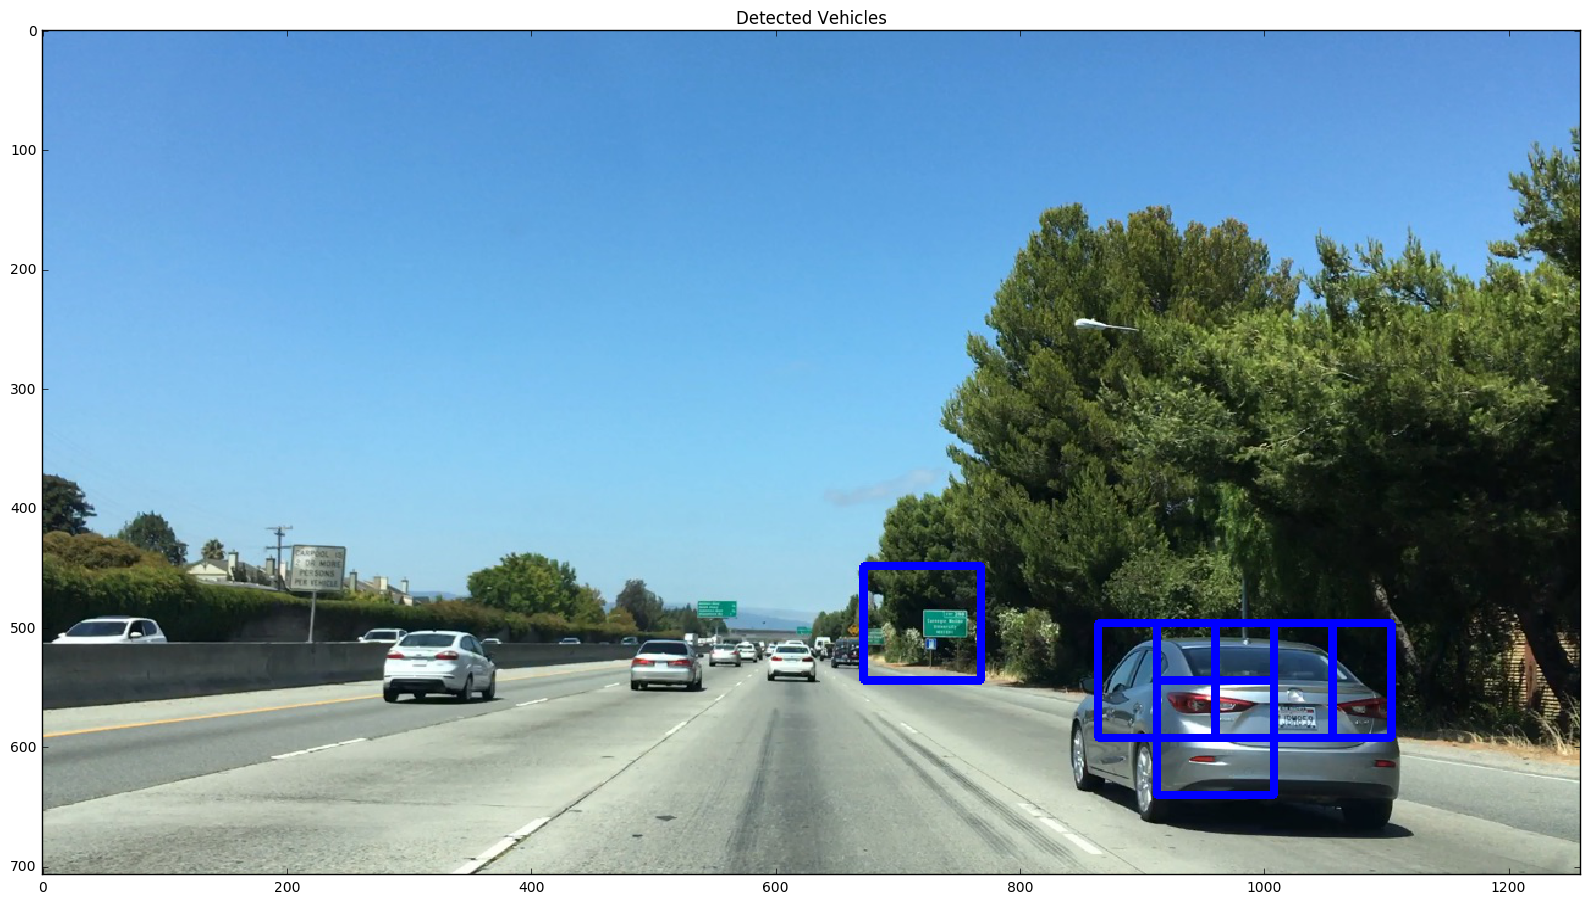

In [76]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
c_sample_size = len(cars) # 500
nc_sample_size = len(notcars)
cars = cars[0:c_sample_size]
notcars = notcars[0:nc_sample_size]

# params = Params(colorspace='YCrCb', orient=8, pix_per_cell=7, cell_per_block=2, hog_channel='ALL') #99-100%
# params = Params(colorspace='YUV', orient=8, pix_per_cell=7, cell_per_block=2, hog_channel='ALL') #99-100%
# params = Params(colorspace='LUV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL') #99-100%
# params = Params(colorspace='HLS', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL') #99-100%
# params = Params(colorspace='HSV', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel='ALL') #99-100%
params = Params(colorspace='YCrCb', orient=8, pix_per_cell=4, cell_per_block=2, hog_channel=1) #99-100%

### TODO: Tweak these parameters and see how the results change.
color_space = params.colorspace # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = params.orient  # HOG orientations
pix_per_cell = params.pix_per_cell # HOG pixels per cell
cell_per_block = params.cell_per_block # HOG cells per block
hog_channel = params.hog_channel # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('notes/bbox-example-image.jpg')
draw_image = np.copy(image)
print(image.shape[0:2][::-1])
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# plt.imshow(window_img)
PlotImageOp(window_img, title="Detected Vehicles").perform()

#### 2. Show some examples of test images to demonstrate how your pipeline is working.  What did you do to optimize the performance of your classifier?

Ultimately I searched on two scales using YCrCb 3-channel HOG features plus spatially binned color and histograms of color in the feature vector, which provided a nice result.  Here are some example images:

![alt text][image4]

---

### Video Implementation

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

Here's a [link to my video result](./project_video.mp4)

#### 2. Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

I recorded the positions of positive detections in each frame of the video.  From the positive detections I created a heatmap and then thresholded that map to identify vehicle positions.  I then used `scipy.ndimage.measurements.label()` to identify individual blobs in the heatmap.  I then assumed each blob corresponded to a vehicle.  I constructed bounding boxes to cover the area of each blob detected.  

Here's an example result showing the heatmap from a series of frames of video, the result of `scipy.ndimage.measurements.label()` and the bounding boxes then overlaid on the last frame of video:

1 cars found


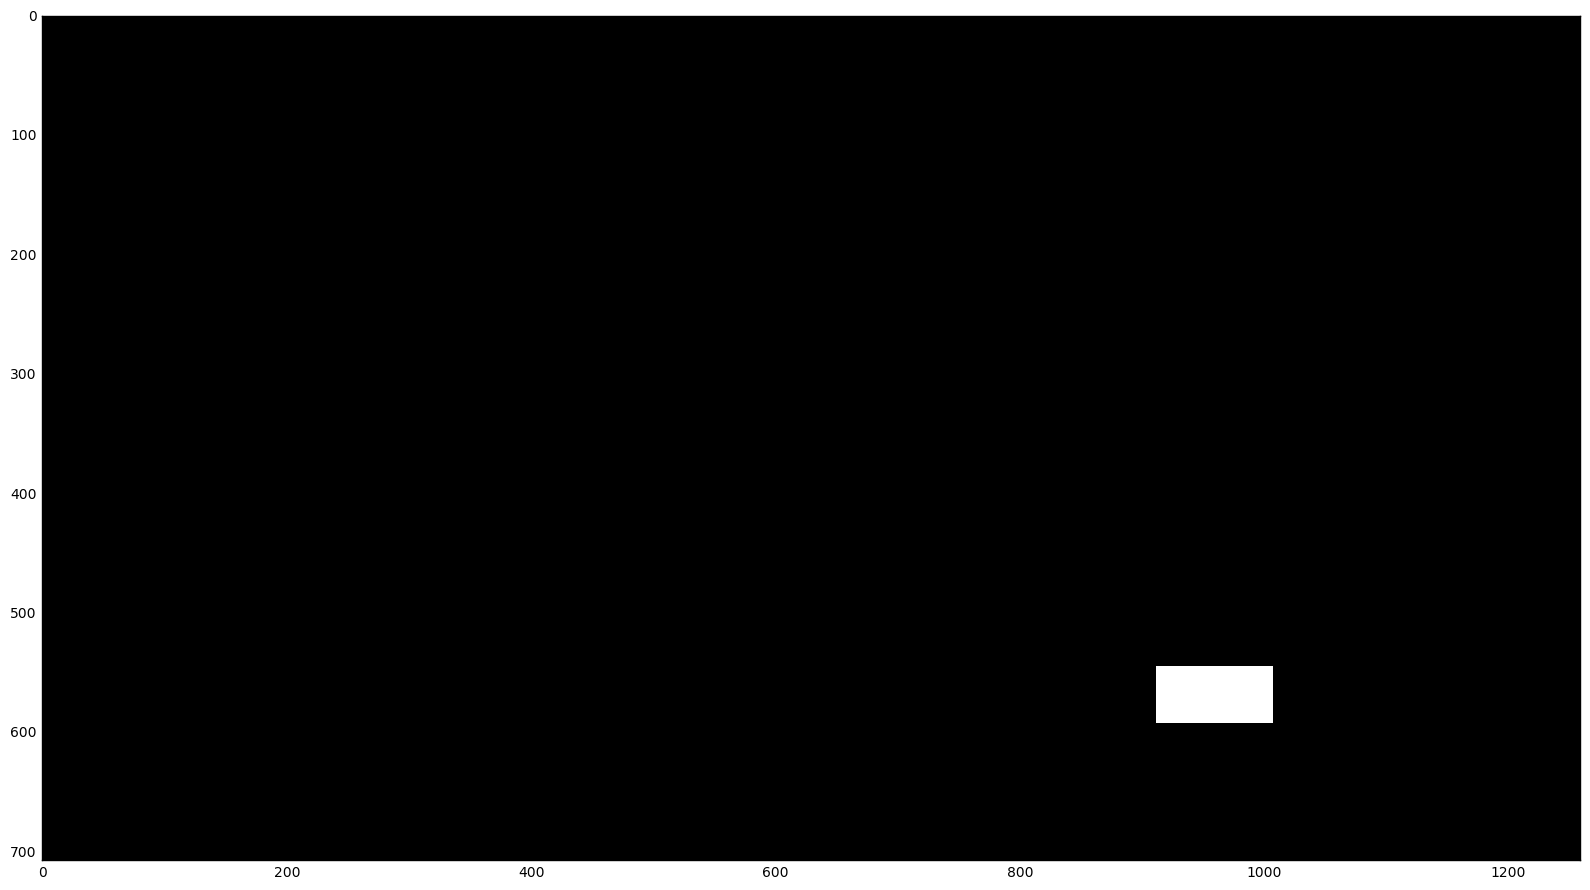

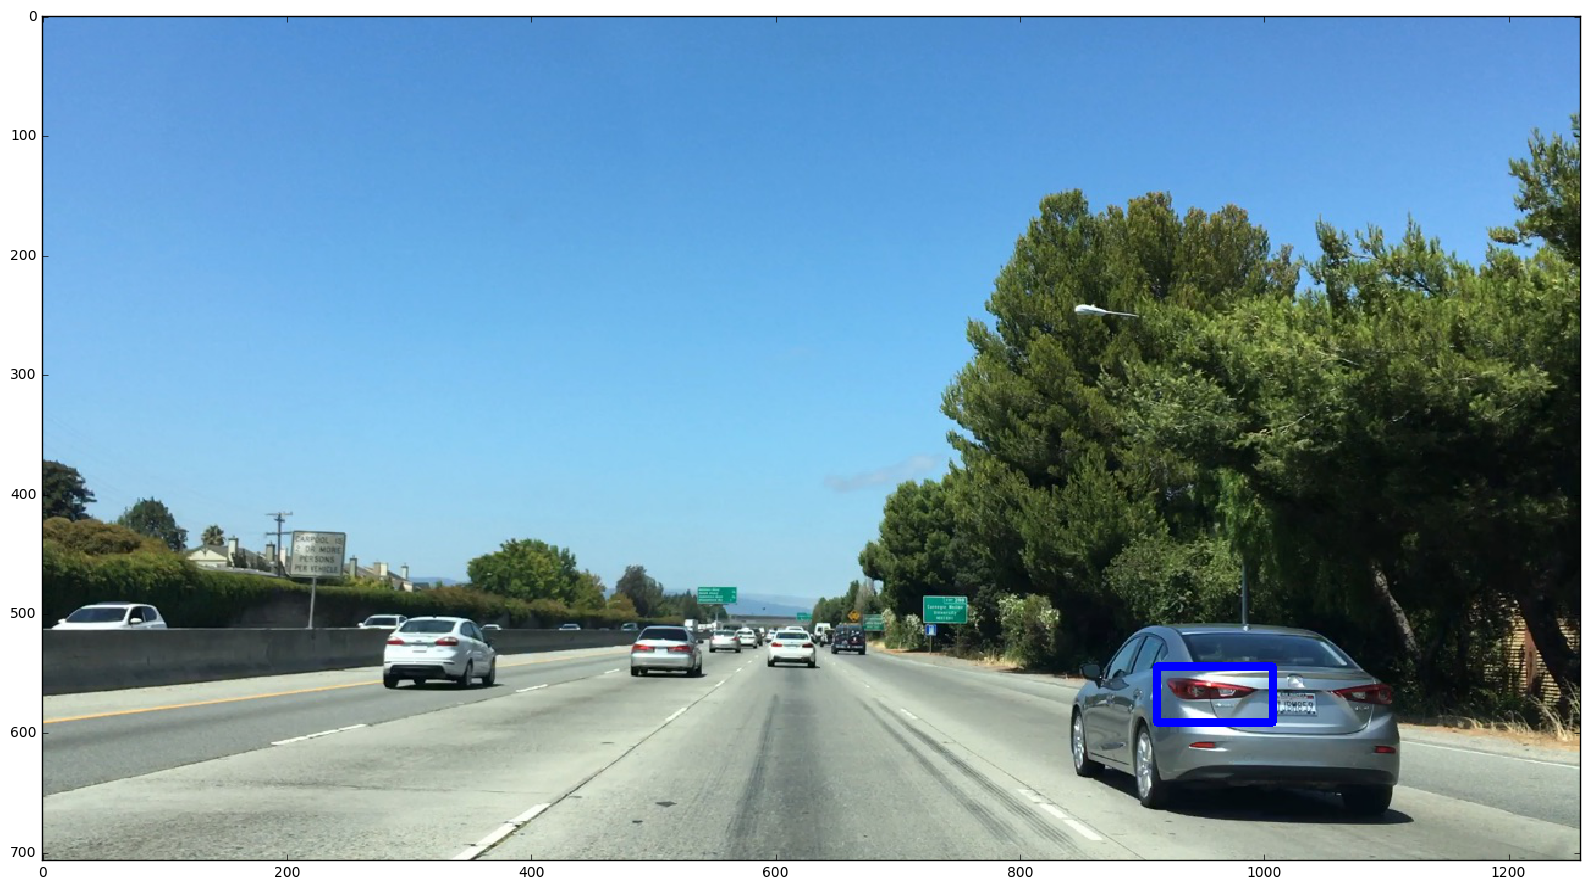

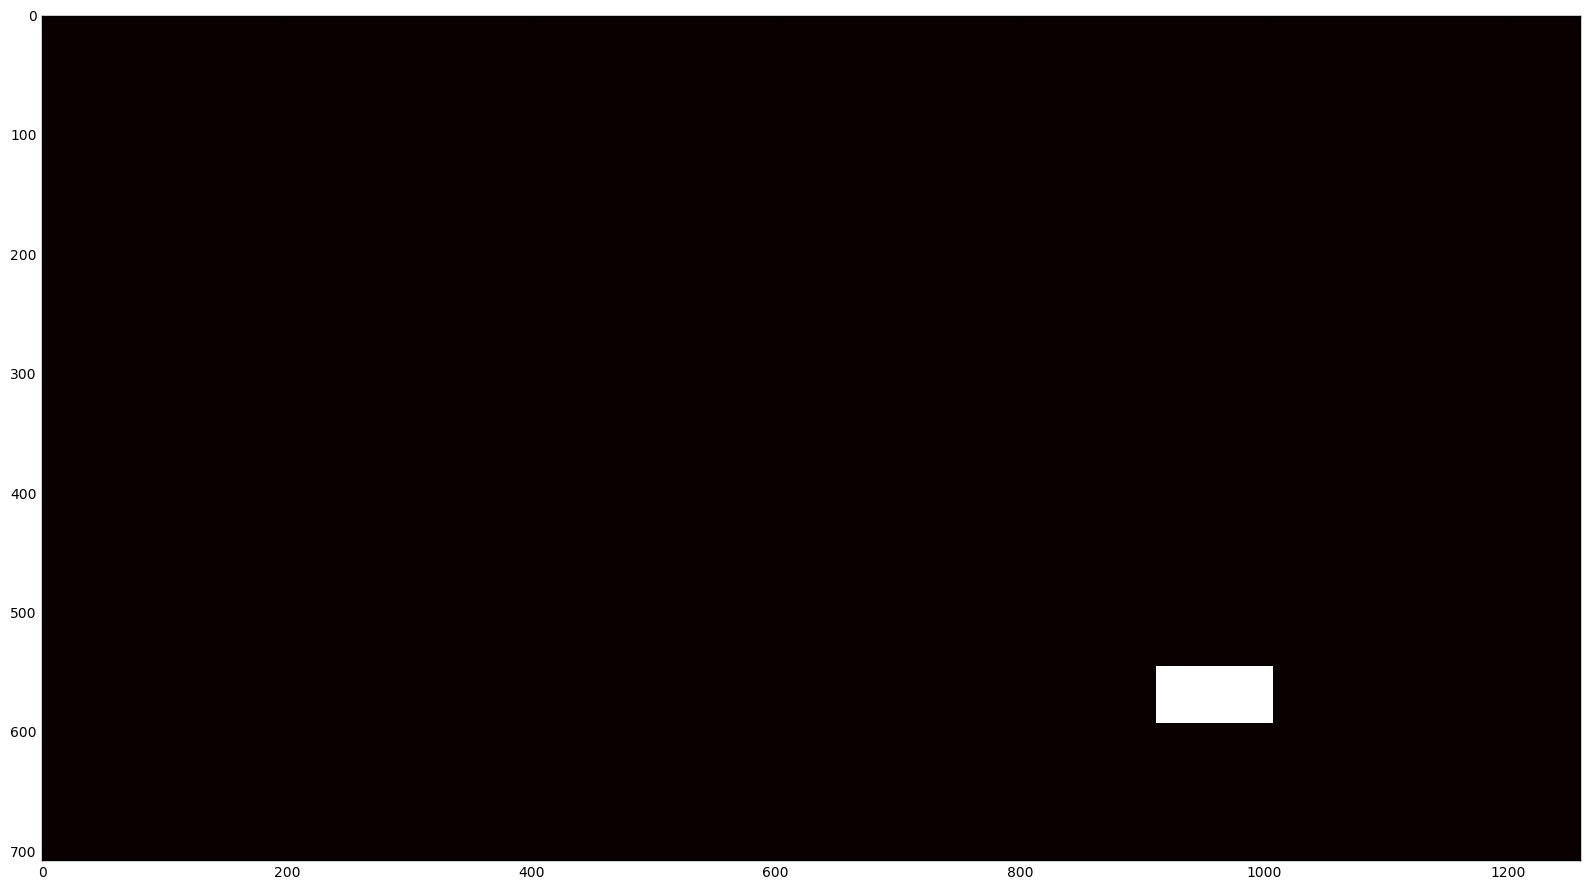

In [78]:
# Read in the last image shown above 
image = mpimg.imread('notes/bbox-example-image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

from scipy.ndimage.measurements import label

heatmap = add_heat(heat, hot_windows)
heatmap = apply_threshold(heatmap, 2)
labels = label(heatmap)
print(labels[1], 'cars found')
# plt.imshow(labels[0], cmap='gray')
# plt.show()
PlotImageOp(labels[0], cmap='gray').perform()

draw_img = draw_labeled_bboxes(np.copy(image), labels)
# Display the image
PlotImageOp(draw_img).perform()
# plt.imshow(draw_img)

final_map = np.clip(heatmap-2, 0, 255)
PlotImageOp(final_map, cmap='hot').perform()

### Here are six frames and their corresponding heatmaps:

![alt text][image5]

### Here is the output of `scipy.ndimage.measurements.label()` on the integrated heatmap from all six frames:
![alt text][image6]

### Here the resulting bounding boxes are drawn onto the last frame in the series:
![alt text][image7]

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further. 